In [2]:
import pandas as pd
import numpy as np
import torch
import umap

from torch import nn
import matplotlib.pyplot as plt

from matplotlib.lines import Line2D
import matplotlib.cm as cm

from rdkit.Chem import MolFromSmiles, DataStructs
from rdkit.Chem.AllChem import GetMorganFingerprintAsBitVect

In [3]:
w = torch.load('../analysis/DDC_BDB_best_epoch_30.ckpt', map_location=torch.device('cpu'))

In [4]:
d_enc = nn.Sequential(nn.Linear(1024, 1024), nn.ReLU(), nn.Dropout(0.2),
                      nn.Linear(1024, 1024), nn.ReLU(), nn.Dropout(0.2),
                      nn.Linear(1024, 1024), nn.ReLU(), nn.Dropout(0.2),
                      nn.Linear(1024, 1024), nn.ReLU(), nn.Dropout(0.2))

In [5]:
d_enc.load_state_dict({k[10:]: v for k, v in w['state_dict'].items() if k.startswith('d_encoder')}, strict=False)

<All keys matched successfully>

In [6]:
d_enc.eval()

Sequential(
  (0): Linear(in_features=1024, out_features=1024, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.2, inplace=False)
  (3): Linear(in_features=1024, out_features=1024, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.2, inplace=False)
  (6): Linear(in_features=1024, out_features=1024, bias=True)
  (7): ReLU()
  (8): Dropout(p=0.2, inplace=False)
  (9): Linear(in_features=1024, out_features=1024, bias=True)
  (10): ReLU()
  (11): Dropout(p=0.2, inplace=False)
)

In [7]:
bdb_ddc = pd.read_csv('../analysis/bindingdb_ki_cliff_pairs_ta1_ts0.9_r_wt.csv')

In [8]:
target_pairs_count = bdb_ddc.groupby('target').apply(lambda x: x[['drug1', 'drug2']].apply(frozenset, axis=1).nunique())

C:\Users\regin\AppData\Local\Temp\ipykernel_8576\936879337.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  target_pairs_count = bdb_ddc.groupby('target').apply(lambda x: x[['drug1', 'drug2']].apply(frozenset, axis=1).nunique())


In [183]:
target_pairs_count

target
0       27
1      198
2        3
3      291
4       20
      ... 
671      1
672      2
673      1
674      1
675    114
Length: 676, dtype: int64

# target 669 

In [9]:
t669 = bdb_ddc[bdb_ddc['target'] == 669]

In [10]:
t669['drug1'].value_counts()

drug1
US10213433, Compound 18::US11369599, Compound 18::US9125913, 177::US9174982, 18                                                                    370
US9125913, 310::US9125913, 312                                                                                                                     319
US10213433, Compound 89::US11369599, Compound 89::US9125913, 173::US9174982, 89                                                                    312
ABT-199::BDBM189459::US10213433, Compound 5::US10377755, Example ABT-199::US11318134, Example ABT-199::US11369599, Compound 369::US9174982, 369    297
US10213433, Compound 91::US11369599, Compound 91::US9125913, 174::US9174982, 91                                                                    263
                                                                                                                                                  ... 
US9125913, 65                                                                           

In [175]:
t669[t669['drug1']=='US10213433, Compound 18::US11369599, Compound 18::US9125913, 177::US9174982, 18']['cliff'].value_counts()

cliff
0    223
1    147
Name: count, dtype: int64

In [176]:
t669_d1_d = t669[t669['drug1']=='US10213433, Compound 18::US11369599, Compound 18::US9125913, 177::US9174982, 18']

In [178]:
dr1_r = pd.DataFrame({'drug1': ['US10213433, Compound 18::US11369599, Compound 18::US9125913, 177::US9174982, 18'], 
                   'drug2': ['US10213433, Compound 18::US11369599, Compound 18::US9125913, 177::US9174982, 18'], 
                   'cliff': [2], # setting cliff to be different from others
                   'target': [669], 
                   'smiles1': ['CC1(C)CCC(CN2CCN(CC2)c2ccc(C(=O)NS(=O)(=O)c3ccc(NCC4CCOCC4)c(c3)[N+]([O-])=O)c(Oc3ccc4[nH]ccc4c3)c2)=C(C1)c1ccc(Cl)cc1'], 
                   'smiles2': ['CC1(C)CCC(CN2CCN(CC2)c2ccc(C(=O)NS(=O)(=O)c3ccc(NCC4CCOCC4)c(c3)[N+]([O-])=O)c(Oc3ccc4[nH]ccc4c3)c2)=C(C1)c1ccc(Cl)cc1']})

t669_d1_d = pd.concat([t669_d1_d, dr1_r], axis=0)

In [180]:
smiles_l = t669_d1_d['smiles2'].tolist()

In [181]:
features_l = []
for s in smiles_l:    
    mol = MolFromSmiles(s)
    if mol is not None:
        fp = GetMorganFingerprintAsBitVect(mol, 2, 1024)
        arr = np.zeros((0,), dtype=np.int8)
        DataStructs.ConvertToNumpyArray(fp, arr)
        features_l.append(torch.tensor(arr, dtype=torch.float32))
    else:
        print(s)

In [185]:
out_669 = d_enc(torch.stack(features_l)).detach().numpy()

In [186]:
out_669.shape

(371, 1024)

In [187]:
u_669 = umap.UMAP(random_state=42)

In [191]:
umap_res_669 = u_669.fit_transform(out_669)

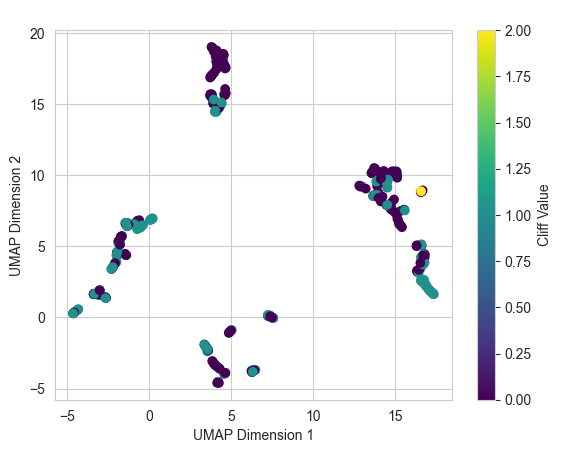

In [192]:
plt.scatter(umap_res_669[:, 0], umap_res_669[:, 1], c = t669_d1_d['cliff'], cmap='viridis')
plt.title(' ')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.colorbar(label='Cliff Value')
plt.show()

trying another target

# Target 517

In [88]:
t517 = bdb_ddc[bdb_ddc['target'] == 517]

In [185]:
t517['drug1'].value_counts()

drug1
US9079866, 44::US9745328, Compound 44::US9884878, Compound 44       72
US9079866, 43::US9745328, Compound 43::US9884878, Compound 43       72
US9079866, 48::US9745328, Compound 48::US9884878, Compound 48       66
US9079866, 46::US9745328, Compound 46::US9884878, Compound 46       66
US9079866, 53::US9745328, Compound 53::US9884878, Compound 53       65
                                                                    ..
US9073876, 283::US9732093, Compound 283                              1
US9073876, 143::US9732093, Compound 143                              1
US9079866, 326::US9745328, Compound 326::US9884878, Compound 326     1
US9079866, 736::US9745328, Compound 736::US9884878, Compound 736     1
US9073876, 315::US9732093, Compound 315                              1
Name: count, Length: 1264, dtype: int64

In [89]:
t517[t517['drug1']=='US9079866, 44::US9745328, Compound 44::US9884878, Compound 44']['cliff'].value_counts()

cliff
0    44
1    28
Name: count, dtype: int64

In [90]:
t517_d1_d = t517[t517['drug1']=='US9079866, 44::US9745328, Compound 44::US9884878, Compound 44']

In [91]:
dr1 = pd.DataFrame({'drug1': ['US9079866, 44::US9745328, Compound 44::US9884878, Compound 44'], 
                   'drug2': ['US9079866, 44::US9745328, Compound 44::US9884878, Compound 44'], 
                   'cliff': [2], 
                   'target': [517], 
                   'smiles1': ['Nc1cnc(cn1)-c1ccc(cc1F)-c1ccccc1S(=O)(=O)N1CCOCC1'], 
                   'smiles2': ['Nc1cnc(cn1)-c1ccc(cc1F)-c1ccccc1S(=O)(=O)N1CCOCC1']})

t517_d1_d = pd.concat([t517_d1_d, dr1], axis=0)

In [92]:
smiles = t517_d1_d['smiles2'].tolist()

In [93]:
features = []
for s in smiles:    
    mol = MolFromSmiles(s)
    if mol is not None:
        fp = GetMorganFingerprintAsBitVect(mol, 2, 1024)
        arr = np.zeros((0,), dtype=np.int8)
        DataStructs.ConvertToNumpyArray(fp, arr)
        features.append(torch.tensor(arr, dtype=torch.float32))
    else:
        print(s)

In [15]:
out = d_enc(torch.stack(features)).detach().numpy()

In [16]:
u1 = umap.UMAP(random_state=42)
umap_res1 = u1.fit_transform(out)

C:\Users\regin\Documents\git\AC-DTI\venv\Lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


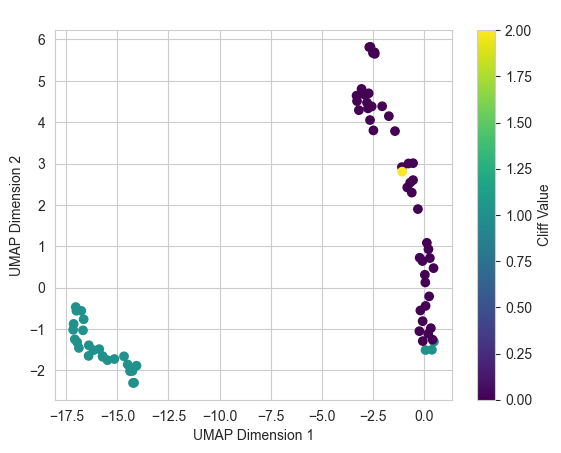

In [20]:
plt.scatter(umap_res1[:, 0], umap_res1[:, 1], c = t517_d1_d['cliff'], cmap='viridis')
plt.title(' ')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.colorbar(label='Cliff Value')
plt.show()

In [17]:
u_init = umap.UMAP(random_state=42)
umap_res_init = u_init.fit_transform(features)

C:\Users\regin\Documents\git\AC-DTI\venv\Lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


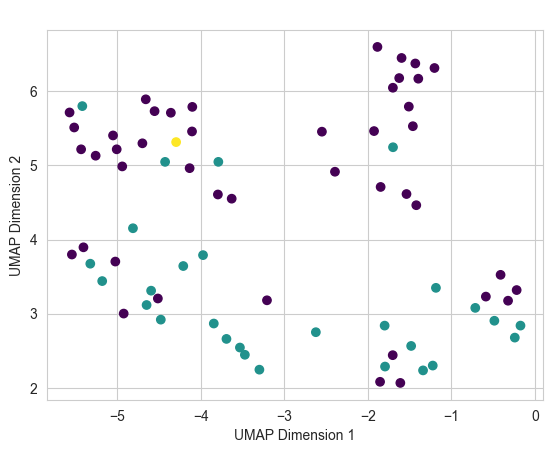

In [52]:
plt.scatter(umap_res_init[:, 0], umap_res_init[:, 1], c = t517_d1_d['cliff'], cmap='viridis')
plt.title(' ')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.show()

In [18]:
d_enc

Sequential(
  (0): Linear(in_features=1024, out_features=1024, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.2, inplace=False)
  (3): Linear(in_features=1024, out_features=1024, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.2, inplace=False)
  (6): Linear(in_features=1024, out_features=1024, bias=True)
  (7): ReLU()
  (8): Dropout(p=0.2, inplace=False)
  (9): Linear(in_features=1024, out_features=1024, bias=True)
  (10): ReLU()
  (11): Dropout(p=0.2, inplace=False)
)

In [19]:
d_enc_remove_last = d_enc[:-3]

In [24]:
d_enc_remove_last

Sequential(
  (0): Linear(in_features=1024, out_features=1024, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.2, inplace=False)
  (3): Linear(in_features=1024, out_features=1024, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.2, inplace=False)
  (6): Linear(in_features=1024, out_features=1024, bias=True)
  (7): ReLU()
  (8): Dropout(p=0.2, inplace=False)
)

In [20]:
out_remove_last = d_enc_remove_last(torch.stack(features)).detach().numpy()
u_rl = umap.UMAP(random_state=42)
umap_res_rl = u_rl.fit_transform(out_remove_last)

C:\Users\regin\Documents\git\AC-DTI\venv\Lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [21]:
d_enc_remove_2last = d_enc[:-6]

In [27]:
d_enc_remove_2last

Sequential(
  (0): Linear(in_features=1024, out_features=1024, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.2, inplace=False)
  (3): Linear(in_features=1024, out_features=1024, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.2, inplace=False)
)

In [22]:
out_remove_2last = d_enc_remove_2last(torch.stack(features)).detach().numpy()
u_r2l = umap.UMAP(random_state=42)
umap_res_r2l = u_r2l.fit_transform(out_remove_2last)

C:\Users\regin\Documents\git\AC-DTI\venv\Lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [23]:
d_enc_remove_3last = d_enc[:-9]

In [30]:
d_enc_remove_3last

Sequential(
  (0): Linear(in_features=1024, out_features=1024, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.2, inplace=False)
)

In [24]:
out_remove_3last = d_enc_remove_3last(torch.stack(features)).detach().numpy()
u_r3l = umap.UMAP(random_state=42)
umap_res_r3l = u_r3l.fit_transform(out_remove_3last)

C:\Users\regin\Documents\git\AC-DTI\venv\Lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


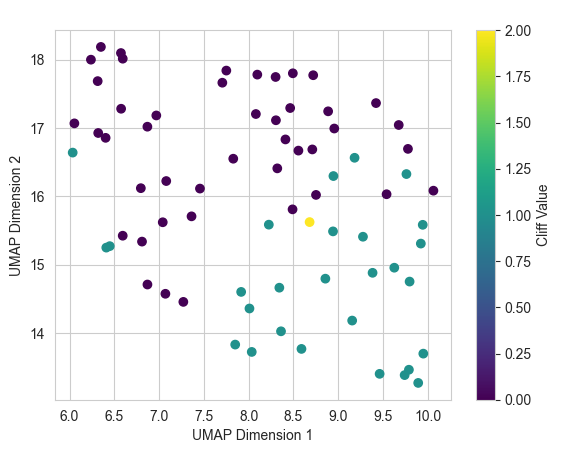

In [136]:
plt.scatter(umap_res_r3l[:, 0], umap_res_r3l[:, 1], c = t517_d1_d['cliff'], cmap='viridis')
plt.title(' ')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.colorbar(label='Cliff Value')
plt.show()

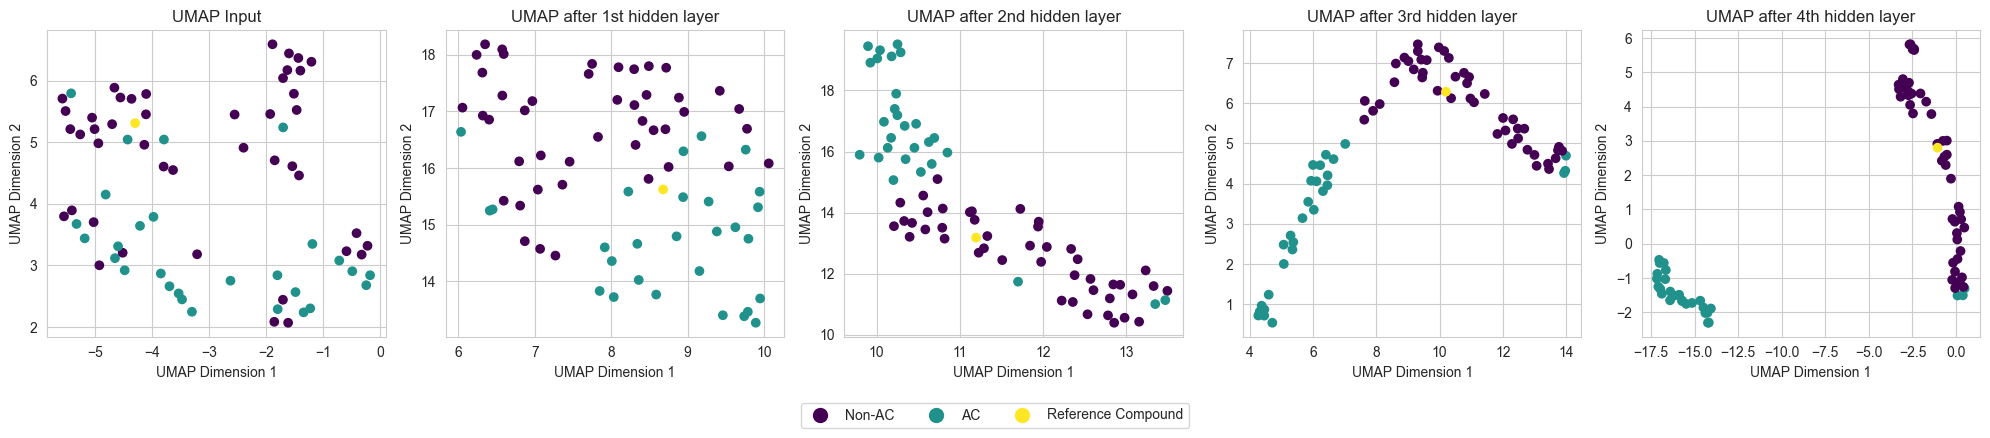

In [25]:
fig, axes = plt.subplots(1, 5, figsize=(20, 4))

scatter0 = axes[0].scatter(umap_res_init[:, 0], umap_res_init[:, 1], c=t517_d1_d['cliff'], cmap='viridis')
axes[0].set_title('UMAP Input')
axes[0].set_xlabel('UMAP Dimension 1')
axes[0].set_ylabel('UMAP Dimension 2')

scatter1 = axes[1].scatter(umap_res_r3l[:, 0], umap_res_r3l[:, 1], c=t517_d1_d['cliff'], cmap='viridis')
axes[1].set_title('UMAP after 1st hidden layer')
axes[1].set_xlabel('UMAP Dimension 1')
axes[1].set_ylabel('UMAP Dimension 2')

scatter2 = axes[2].scatter(umap_res_r2l[:, 0], umap_res_r2l[:, 1], c=t517_d1_d['cliff'], cmap='viridis')
axes[2].set_title('UMAP after 2nd hidden layer')
axes[2].set_xlabel('UMAP Dimension 1')
axes[2].set_ylabel('UMAP Dimension 2')

scatter3 = axes[3].scatter(umap_res_rl[:, 0], umap_res_rl[:, 1], c=t517_d1_d['cliff'], cmap='viridis')
axes[3].set_title('UMAP after 3rd hidden layer')
axes[3].set_xlabel('UMAP Dimension 1')
axes[3].set_ylabel('UMAP Dimension 2')

scatter4 = axes[4].scatter(umap_res1[:, 0], umap_res1[:, 1], c=t517_d1_d['cliff'], cmap='viridis')
axes[4].set_title('UMAP after 4th hidden layer')
axes[4].set_xlabel('UMAP Dimension 1')
axes[4].set_ylabel('UMAP Dimension 2')

legend_labels = ['Non-AC', 'AC', 'Reference Compound']
num_unique_values = len(t517_d1_d['cliff'].unique())
viridis_colors = cm.viridis(np.linspace(0, 1, num_unique_values))
legend_colors = viridis_colors[:3]

legend_handles = [Line2D([0], [0], marker='o', markersize=10, color=color, label=label, linestyle='None') for label, color in zip(legend_labels, legend_colors)]
fig.legend(handles=legend_handles, labels=legend_labels, loc='lower center', bbox_to_anchor=(0.5, -0.1), ncol=3)

#plt.savefig('../analysis/UMAP_Out.png')
plt.tight_layout()
plt.show()

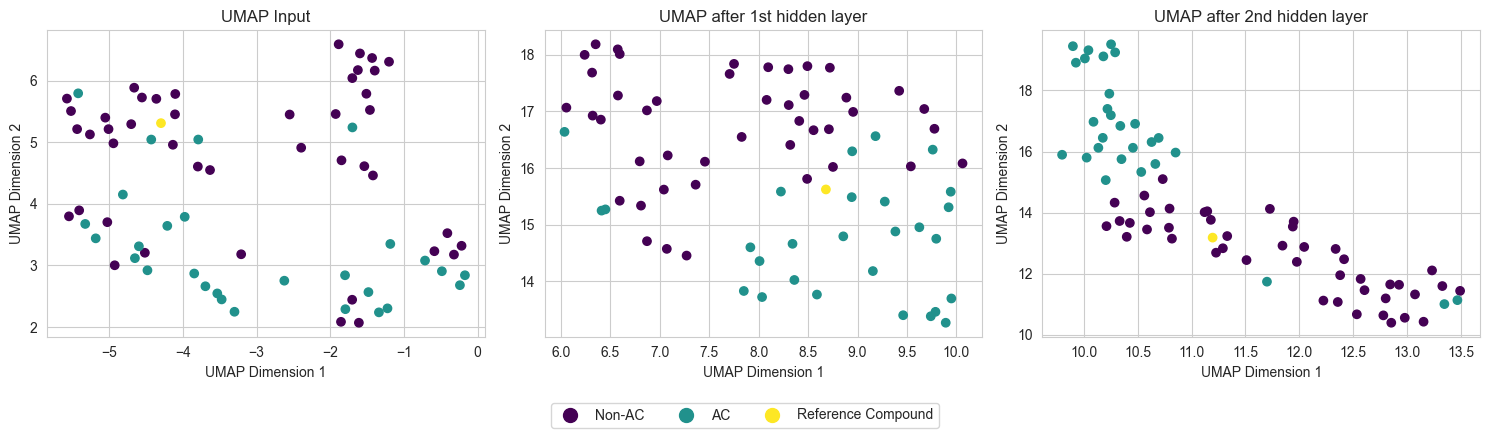

In [200]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

scatter0 = axes[0].scatter(umap_res_init[:, 0], umap_res_init[:, 1], c=t517_d1_d['cliff'], cmap='viridis')
axes[0].set_title('UMAP Input')
axes[0].set_xlabel('UMAP Dimension 1')
axes[0].set_ylabel('UMAP Dimension 2')

scatter1 = axes[1].scatter(umap_res_r3l[:, 0], umap_res_r3l[:, 1], c=t517_d1_d['cliff'], cmap='viridis')
axes[1].set_title('UMAP after 1st hidden layer')
axes[1].set_xlabel('UMAP Dimension 1')
axes[1].set_ylabel('UMAP Dimension 2')

scatter2 = axes[2].scatter(umap_res_r2l[:, 0], umap_res_r2l[:, 1], c=t517_d1_d['cliff'], cmap='viridis')
axes[2].set_title('UMAP after 2nd hidden layer')
axes[2].set_xlabel('UMAP Dimension 1')
axes[2].set_ylabel('UMAP Dimension 2')

legend_labels = ['Non-AC', 'AC', 'Reference Compound']
num_unique_values = len(t517_d1_d['cliff'].unique())
viridis_colors = cm.viridis(np.linspace(0, 1, num_unique_values))
legend_colors = viridis_colors[:3]

legend_handles = [Line2D([0], [0], marker='o', markersize=10, color=color, label=label, linestyle='None') for label, color in zip(legend_labels, legend_colors)]
fig.legend(handles=legend_handles, labels=legend_labels, loc='lower center', bbox_to_anchor=(0.5, -0.1), ncol=3)

plt.savefig('../analysis/UMAP_Out_part1.png')
plt.tight_layout()
plt.show()

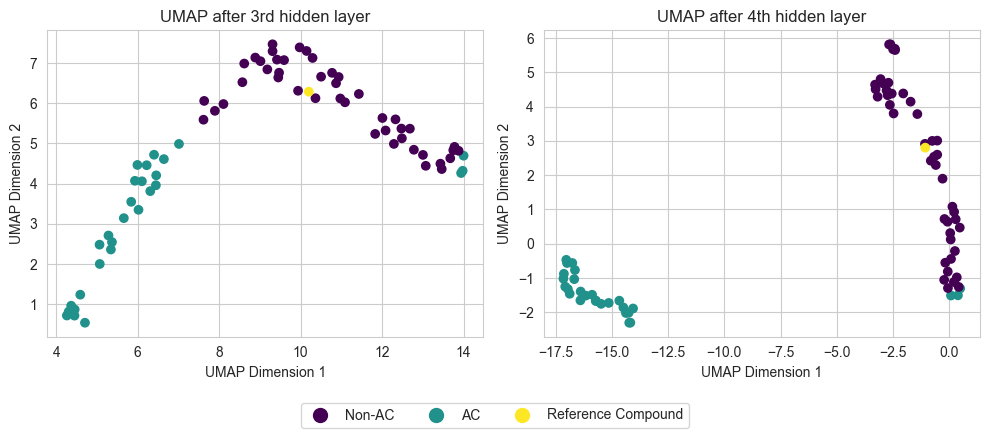

In [202]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

scatter3 = axes[0].scatter(umap_res_rl[:, 0], umap_res_rl[:, 1], c=t517_d1_d['cliff'], cmap='viridis')
axes[0].set_title('UMAP after 3rd hidden layer')
axes[0].set_xlabel('UMAP Dimension 1')
axes[0].set_ylabel('UMAP Dimension 2')

scatter4 = axes[1].scatter(umap_res1[:, 0], umap_res1[:, 1], c=t517_d1_d['cliff'], cmap='viridis')
axes[1].set_title('UMAP after 4th hidden layer')
axes[1].set_xlabel('UMAP Dimension 1')
axes[1].set_ylabel('UMAP Dimension 2')

legend_labels = ['Non-AC', 'AC', 'Reference Compound']
num_unique_values = len(t517_d1_d['cliff'].unique())
viridis_colors = cm.viridis(np.linspace(0, 1, num_unique_values))
legend_colors = viridis_colors[:3]

legend_handles = [Line2D([0], [0], marker='o', markersize=10, color=color, label=label, linestyle='None') for label, color in zip(legend_labels, legend_colors)]
fig.legend(handles=legend_handles, labels=legend_labels, loc='lower center', bbox_to_anchor=(0.5, -0.1), ncol=3)

plt.savefig('../analysis/UMAP_Out_part2.png')
plt.tight_layout()
plt.show()

# t-SNE

In [97]:
from sklearn.manifold import TSNE

In [114]:
features_array = np.array(features)

In [117]:
tsne_init = TSNE(n_components=2, random_state=42)
tsne_res_init = tsne_init.fit_transform(features_array)

tsne_r3l = TSNE(n_components=2, random_state=42)
tsne_res_r3l = tsne_r3l.fit_transform(out_remove_3last)

tsne_r2l = TSNE(n_components=2, random_state=42)
tsne_res_r2l = tsne_r2l.fit_transform(out_remove_2last)

tsne_rl = TSNE(n_components=2, random_state=42)
tsne_res_rl = tsne_rl.fit_transform(out_remove_last)

tsne_out = TSNE(n_components=2, random_state=42)
tsne_results = tsne_out.fit_transform(out)

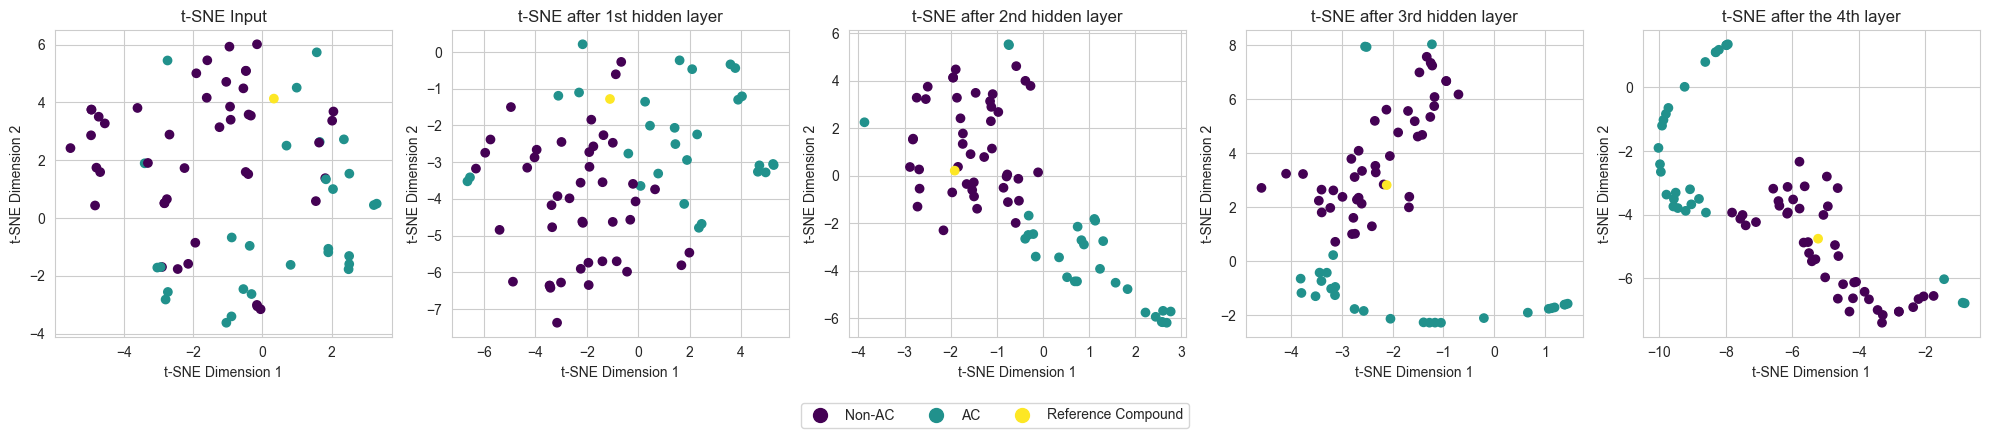

In [205]:
fig, axes = plt.subplots(1, 5, figsize=(20, 4))  

axes[0].scatter(tsne_res_init[:, 0], tsne_res_init[:, 1], c=t517_d1_d['cliff'], cmap='viridis')
axes[0].set_title('t-SNE Input')
axes[0].set_xlabel('t-SNE Dimension 1')
axes[0].set_ylabel('t-SNE Dimension 2')

axes[1].scatter(tsne_res_r3l[:, 0], tsne_res_r3l[:, 1], c=t517_d1_d['cliff'], cmap='viridis')
axes[1].set_title('t-SNE after 1st hidden layer')
axes[1].set_xlabel('t-SNE Dimension 1')
axes[1].set_ylabel('t-SNE Dimension 2')

axes[2].scatter(tsne_res_r2l[:, 0], tsne_res_r2l[:, 1], c=t517_d1_d['cliff'], cmap='viridis')
axes[2].set_title('t-SNE after 2nd hidden layer')
axes[2].set_xlabel('t-SNE Dimension 1')
axes[2].set_ylabel('t-SNE Dimension 2')

axes[3].scatter(tsne_res_rl[:, 0], tsne_res_rl[:, 1], c=t517_d1_d['cliff'], cmap='viridis')
axes[3].set_title('t-SNE after 3rd hidden layer')
axes[3].set_xlabel('t-SNE Dimension 1')
axes[3].set_ylabel('t-SNE Dimension 2')

axes[4].scatter(tsne_results[:, 0], tsne_results[:, 1], c=t517_d1_d['cliff'], cmap='viridis')
axes[4].set_title('t-SNE after the 4th layer')
axes[4].set_xlabel('t-SNE Dimension 1')
axes[4].set_ylabel('t-SNE Dimension 2')

legend_labels = ['Non-AC', 'AC', 'Reference Compound']
num_unique_values = len(t517_d1_d['cliff'].unique())
viridis_colors = cm.viridis(np.linspace(0, 1, num_unique_values))
legend_colors = viridis_colors[:3]

legend_handles = [Line2D([0], [0], marker='o', markersize=10, color=color, label=label, linestyle='None') for label, color in zip(legend_labels, legend_colors)]
fig.legend(handles=legend_handles, labels=legend_labels, loc='lower center', bbox_to_anchor=(0.5, -0.1), ncol=3)
plt.tight_layout()
plt.savefig('../analysis/tSNE_Out.png')
plt.show()

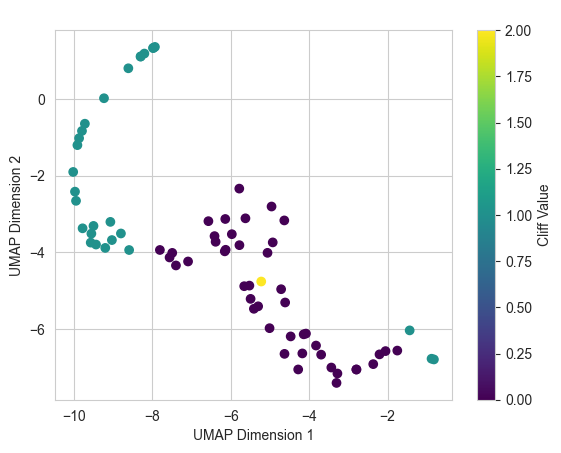

In [121]:
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c = t517_d1_d['cliff'], cmap='viridis')
plt.title(' ')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.show()

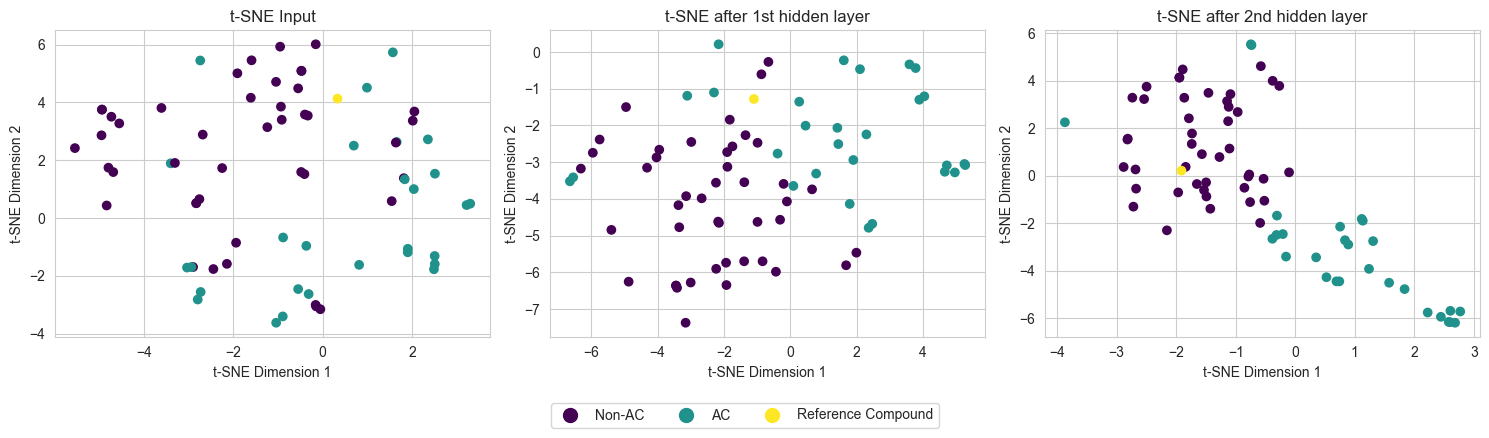

In [170]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

scatter0 = axes[0].scatter(tsne_res_init[:, 0], tsne_res_init[:, 1], c=t517_d1_d['cliff'], cmap='viridis')
axes[0].set_title('t-SNE Input')
axes[0].set_xlabel('t-SNE Dimension 1')
axes[0].set_ylabel('t-SNE Dimension 2')

scatter1 = axes[1].scatter(tsne_res_r3l[:, 0], tsne_res_r3l[:, 1], c=t517_d1_d['cliff'], cmap='viridis')
axes[1].set_title('t-SNE after 1st hidden layer')
axes[1].set_xlabel('t-SNE Dimension 1')
axes[1].set_ylabel('t-SNE Dimension 2')

scatter2 = axes[2].scatter(tsne_res_r2l[:, 0], tsne_res_r2l[:, 1], c=t517_d1_d['cliff'], cmap='viridis')
axes[2].set_title('t-SNE after 2nd hidden layer')
axes[2].set_xlabel('t-SNE Dimension 1')
axes[2].set_ylabel('t-SNE Dimension 2')

legend_labels = ['Non-AC', 'AC', 'Reference Compound']
num_unique_values = len(t517_d1_d['cliff'].unique())
viridis_colors = cm.viridis(np.linspace(0, 1, num_unique_values))
legend_colors = viridis_colors[:3]

legend_handles = [Line2D([0], [0], marker='o', markersize=10, color=color, label=label, linestyle='None') for label, color in zip(legend_labels, legend_colors)]
fig.legend(handles=legend_handles, labels=legend_labels, loc='lower center', bbox_to_anchor=(0.5, -0.1), ncol=3)

plt.tight_layout()
#plt.savefig('../analysis/tSNE_Out_part1.png')
plt.show()

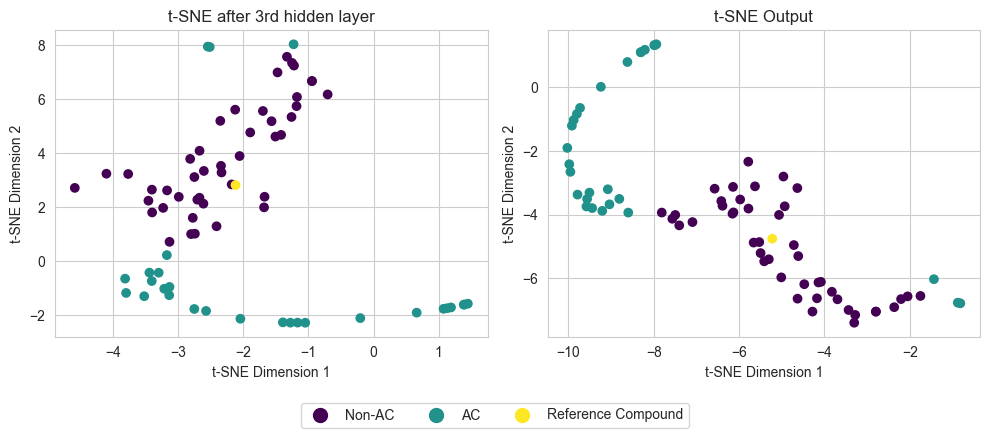

In [171]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

scatter3 = axes[0].scatter(tsne_res_rl[:, 0], tsne_res_rl[:, 1], c=t517_d1_d['cliff'], cmap='viridis')
axes[0].set_title('t-SNE after 3rd hidden layer')
axes[0].set_xlabel('t-SNE Dimension 1')
axes[0].set_ylabel('t-SNE Dimension 2')

scatter4 = axes[1].scatter(tsne_results[:, 0], tsne_results[:, 1], c=t517_d1_d['cliff'], cmap='viridis')
axes[1].set_title('t-SNE Output')
axes[1].set_xlabel('t-SNE Dimension 1')
axes[1].set_ylabel('t-SNE Dimension 2')

legend_labels = ['Non-AC', 'AC', 'Reference Compound']
num_unique_values = len(t517_d1_d['cliff'].unique())
viridis_colors = cm.viridis(np.linspace(0, 1, num_unique_values))
legend_colors = viridis_colors[:3]

legend_handles = [Line2D([0], [0], marker='o', markersize=10, color=color, label=label, linestyle='None') for label, color in zip(legend_labels, legend_colors)]
fig.legend(handles=legend_handles, labels=legend_labels, loc='lower center', bbox_to_anchor=(0.5, -0.1), ncol=3)

plt.tight_layout()
#plt.savefig('../analysis/tSNE_Out_part2.png')
plt.show()

# UMAP analysis

In [26]:
from rdkit.Chem import MolFromSmiles
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.io as pio

In [59]:
data_ki_aff = pd.read_csv('../analysis/bindingdb_ki_d_t_aff_smiles_split-2.csv')

In [28]:
df_plot = pd.DataFrame({
    'UMAP Dimension 1': umap_res1[:, 0],
    'UMAP Dimension 2': umap_res1[:, 1],
    'cliff': t517_d1_d['cliff'],
    'index': t517_d1_d.index
})

fig = px.scatter(
    df_plot,
    x='UMAP Dimension 1',
    y='UMAP Dimension 2',
    color='cliff',
    hover_name='index',  
    color_continuous_scale='Viridis'
)

fig.update_layout(
    title=' ',
    xaxis_title='UMAP Dimension 1',
    yaxis_title='UMAP Dimension 2'
)

fig.show()

In [345]:
df_plot = pd.DataFrame({
    'UMAP Dimension 1': umap_res1[:, 0],
    'UMAP Dimension 2': umap_res1[:, 1],
    'smiles': t517_d1_d['smiles2'],  
    'cliff': t517_d1_d['cliff'],
    'index': t517_d1_d.index
})

df_plot = df_plot.merge(data_ki_aff[['smiles', 'affinity']], on='smiles', how='left')

fig = px.scatter(
    df_plot,
    x='UMAP Dimension 1',
    y='UMAP Dimension 2',
    color='cliff',
    hover_data={'index': True, 'affinity': True},  
    color_continuous_scale='Viridis'
)

fig.update_layout(
    title=' ',
    xaxis_title='UMAP Dimension 1',
    yaxis_title='UMAP Dimension 2'
)

fig.show()

In [29]:
df_plot_init = pd.DataFrame({
    'UMAP Dimension 1': umap_res_init[:, 0],
    'UMAP Dimension 2': umap_res_init[:, 1],
    'smiles': t517_d1_d['smiles2'],  
    'cliff': t517_d1_d['cliff'],
    'index': t517_d1_d.index
})

df_plot_init = df_plot_init.merge(data_ki_aff[['smiles', 'affinity']], on='smiles', how='inner')

df_plot_r3l = pd.DataFrame({
    'UMAP Dimension 1': umap_res_r3l[:, 0],
    'UMAP Dimension 2': umap_res_r3l[:, 1],
    'smiles': t517_d1_d['smiles2'],  
    'cliff': t517_d1_d['cliff'],
    'index': t517_d1_d.index
})

df_plot_r3l = df_plot_r3l.merge(data_ki_aff[['smiles', 'affinity']], on='smiles', how='inner')

df_plot_r2l = pd.DataFrame({
    'UMAP Dimension 1': umap_res_r2l[:, 0],
    'UMAP Dimension 2': umap_res_r2l[:, 1],
    'smiles': t517_d1_d['smiles2'],  
    'cliff': t517_d1_d['cliff'],
    'index': t517_d1_d.index
})

df_plot_r2l = df_plot_r2l.merge(data_ki_aff[['smiles', 'affinity']], on='smiles', how='inner')

df_plot_rl = pd.DataFrame({
    'UMAP Dimension 1': umap_res_rl[:, 0],
    'UMAP Dimension 2': umap_res_rl[:, 1],
    'smiles': t517_d1_d['smiles2'],  
    'cliff': t517_d1_d['cliff'],
    'index': t517_d1_d.index
})

df_plot_rl = df_plot_rl.merge(data_ki_aff[['smiles', 'affinity']], on='smiles', how='inner')

df_plot = pd.DataFrame({
    'UMAP Dimension 1': umap_res1[:, 0],
    'UMAP Dimension 2': umap_res1[:, 1],
    'smiles': t517_d1_d['smiles2'],  
    'cliff': t517_d1_d['cliff'],
    'index': t517_d1_d.index
})

df_plot = df_plot.merge(data_ki_aff[['smiles', 'affinity']], on='smiles', how='inner')

In [30]:
# (2 rows, 3 columns)
fig = make_subplots(
    rows=2, cols=3,
    subplot_titles=('UMAP Input', 'UMAP after 1st hidden layer', 'UMAP after 2nd hidden layer', 
                    'UMAP after 3rd hidden layer', 'UMAP after 4th hidden layer'),
    horizontal_spacing=0.03,
    vertical_spacing=0.15
)

fig1 = px.scatter(
    df_plot_init,
    x='UMAP Dimension 1',
    y='UMAP Dimension 2',
    color='affinity',
    hover_data={'index': True, 'affinity': True, 'cliff': True},  
    color_continuous_scale='Viridis'
)

fig2 = px.scatter(
    df_plot_r3l,
    x='UMAP Dimension 1',
    y='UMAP Dimension 2',
    color='affinity',
    hover_data={'index': True, 'affinity': True, 'cliff': True},  
    color_continuous_scale='Viridis'
)

fig3 = px.scatter(
    df_plot_r2l,
    x='UMAP Dimension 1',
    y='UMAP Dimension 2',
    color='affinity',
    hover_data={'index': True, 'affinity': True, 'cliff': True},  
    color_continuous_scale='Viridis'
)

fig4 = px.scatter(
    df_plot_rl,
    x='UMAP Dimension 1',
    y='UMAP Dimension 2',
    color='affinity',
    hover_data={'index': True, 'affinity': True, 'cliff': True},  
    color_continuous_scale='Viridis'
)

fig5 = px.scatter(
    df_plot,
    x='UMAP Dimension 1',
    y='UMAP Dimension 2',
    color='affinity',
    hover_data={'index': True, 'affinity': True, 'cliff': True},  
    color_continuous_scale='Viridis'
)

fig.add_trace(fig1.data[0], row=1, col=1)
fig.add_trace(fig2.data[0], row=1, col=2)
fig.add_trace(fig3.data[0], row=1, col=3)
fig.add_trace(fig4.data[0], row=2, col=1)
fig.add_trace(fig5.data[0], row=2, col=2)

fig.update_layout(
    showlegend=False,
    coloraxis=dict(colorscale='Viridis', colorbar=dict(title='Affinity')),
    height=800 
)

fig.update_xaxes(title_text="UMAP Dimension 1", row=1, col=1)
fig.update_yaxes(title_text="UMAP Dimension 2", row=1, col=1)

fig.update_xaxes(title_text="UMAP Dimension 1", row=1, col=2)
fig.update_yaxes(title_text="UMAP Dimension 2", row=1, col=2)

fig.update_xaxes(title_text="UMAP Dimension 1", row=1, col=3)
fig.update_yaxes(title_text="UMAP Dimension 2", row=1, col=3)

fig.update_xaxes(title_text="UMAP Dimension 1", row=2, col=1)
fig.update_yaxes(title_text="UMAP Dimension 2", row=2, col=1)

fig.update_xaxes(title_text="UMAP Dimension 1", row=2, col=2)
fig.update_yaxes(title_text="UMAP Dimension 2", row=2, col=2)


fig.show()

pio.write_html(fig, file='../analysis/umap_plots.html', auto_open=True)

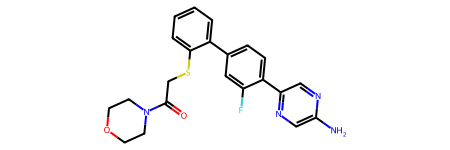

In [350]:
# an outlier on bottom left
MolFromSmiles(t517_d1_d.smiles2[60374])

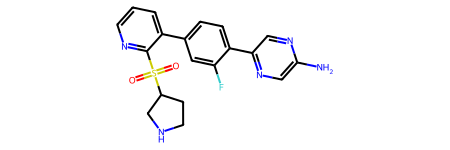

In [351]:
# group on bottom right
MolFromSmiles(t517_d1_d.smiles2[171952])

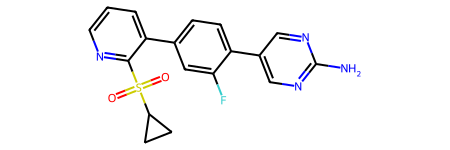

In [329]:
# group on bottom right
MolFromSmiles(t517_d1_d.smiles2[9855])

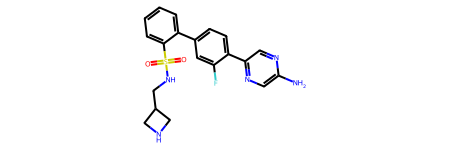

In [330]:
# up right
MolFromSmiles(t517_d1_d.smiles2[202320])

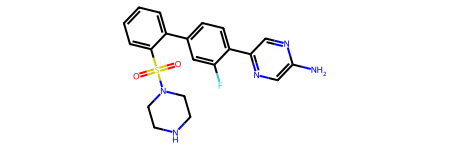

In [331]:
# up right
MolFromSmiles(t517_d1_d.smiles2[140701])

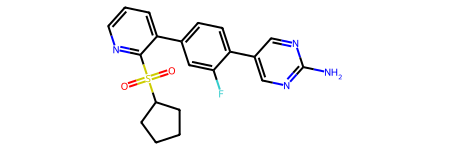

In [332]:
# middle right
MolFromSmiles(t517_d1_d.smiles2[246476])

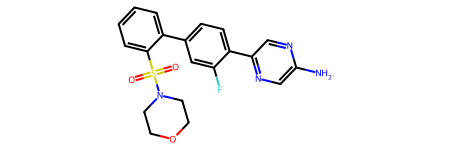

In [333]:
# middle right (reference compound)
MolFromSmiles(t517_d1_d.smiles2[0])

drug1  \
7099    US9079866, 44::US9745328, Compound 44::US9884878, Compound 44   
8064    US9079866, 44::US9745328, Compound 44::US9884878, Compound 44   
9855    US9079866, 44::US9745328, Compound 44::US9884878, Compound 44   
11267   US9079866, 44::US9745328, Compound 44::US9884878, Compound 44   
16653   US9079866, 44::US9745328, Compound 44::US9884878, Compound 44   
...                                                               ...   
242041  US9079866, 44::US9745328, Compound 44::US9884878, Compound 44   
243930  US9079866, 44::US9745328, Compound 44::US9884878, Compound 44   
246476  US9079866, 44::US9745328, Compound 44::US9884878, Compound 44   
249412  US9079866, 44::US9745328, Compound 44::US9884878, Compound 44   
0       US9079866, 44::US9745328, Compound 44::US9884878, Compound 44   

                                                                   drug2  \
7099    US9079866, 361::US9745328, Compound 361::US9884878, Compound 361   
8064    US9079866, 310::US9745328, Compound 310::US9884878, Compound 310   
9855    US9079866, 828::US9745328, Compound 828::US9884878, Compound 828   
11267   US9079866, 579::US9745328, Compound 579::US9884878, Compound 579   
16653   US9079866, 303::US9745328, Compound 303::US9884878, Compound 303   
...                                                                  ...   
242041  US9079866, 805::US9745328, Compound 805::US9884878, Compound 805   
243930  US9079866, 718::US9745328, Compound 718::US9884878, Compound 718   
246476                           US9079866, 809::US9884878, Compound 809   
249412  US9079866, 181::US9745328, Compound 181::US9884878, Compound 181   
0          US9079866, 44::US9745328, Compound 44::US9884878, Compound 44   

                                                  smiles1  \
7099    Nc1cnc(cn1)-c1ccc(cc1F)-c1ccccc1S(=O)(=O)N1CCOCC1   
8064    Nc1cnc(cn1)-c1ccc(cc1F)-c1ccccc1S(=O)(=O)N1CCOCC1   
9855    Nc1cnc(cn1)-c1ccc(cc1F)-c1ccccc1S(=O)(=O)N1CCOCC1   
11267   Nc1cnc(cn1)-c1ccc(cc1F)-c1ccccc1S(=O)(=O)N1CCOCC1   
16653   Nc1cnc(cn1)-c1ccc(cc1F)-c1ccccc1S(=O)(=O)N1CCOCC1   
...                                                   ...   
242041  Nc1cnc(cn1)-c1ccc(cc1F)-c1ccccc1S(=O)(=O)N1CCOCC1   
243930  Nc1cnc(cn1)-c1ccc(cc1F)-c1ccccc1S(=O)(=O)N1CCOCC1   
246476  Nc1cnc(cn1)-c1ccc(cc1F)-c1ccccc1S(=O)(=O)N1CCOCC1   
249412  Nc1cnc(cn1)-c1ccc(cc1F)-c1ccccc1S(=O)(=O)N1CCOCC1   
0       Nc1cnc(cn1)-c1ccc(cc1F)-c1ccccc1S(=O)(=O)N1CCOCC1   

                                                      smiles2  cliff  target  \
7099    Nc1ccc(cn1)-c1ccc(cc1F)-c1ccccc1S(=O)(=O)N1CCC(CO)CC1      0     517   
8064       Nc1ncc(cn1)-c1ccc(cc1F)-c1ccccc1NS(=O)(=O)N1CCOCC1      1     517   
9855           Nc1ncc(cn1)-c1ccc(cc1F)-c1cccnc1S(=O)(=O)C1CC1      1     517   
11267         Nc1nc(cs1)-c1ccc(cc1F)-c1ccccc1S(=O)(=O)N1CCCC1      1     517   
16653       Nc1ncc(cn1)-c1ccc(cc1F)-c1ccccc1S(=O)(=O)N1CCOCC1      1     517   
...                                                       ...    ...     ...   
242041        Nc1ncc(cn1)-c1ccc(cc1F)-c1cccnc1S(=O)(=O)C1CCC1      0     517   
243930      Nc1ncc(cn1)-c1ccc(cc1F)-c1ccccc1S(=O)(=O)c1ncccn1      1     517   
246476       Nc1ncc(cn1)-c1ccc(cc1F)-c1cccnc1S(=O)(=O)C1CCCC1      0     517   
249412      Nc1cnc(cn1)-c1ccc(cc1F)-c1ccccc1NS(=O)(=O)N1CCCC1      0     517   
0           Nc1cnc(cn1)-c1ccc(cc1F)-c1ccccc1S(=O)(=O)N1CCOCC1      2     517   

        split  \
7099      0.0   
8064      0.0   
9855      0.0   
11267     0.0   
16653     0.0   
...       ...   
242041    2.0   
243930    2.0   
246476    2.0   
249412    2.0   
0         NaN   

                                                                                                                                                                                                                                                                                                                                                                                       
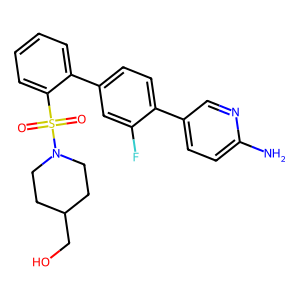
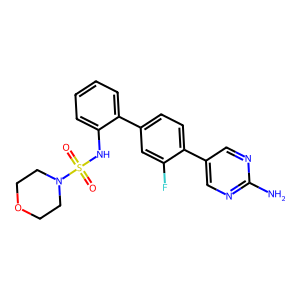
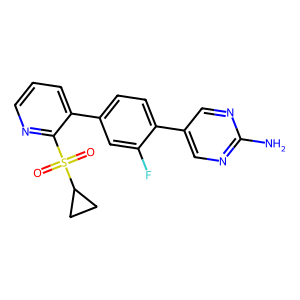
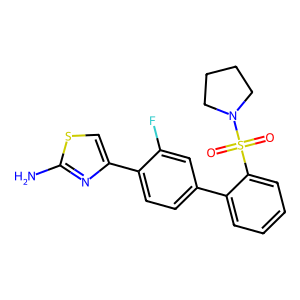
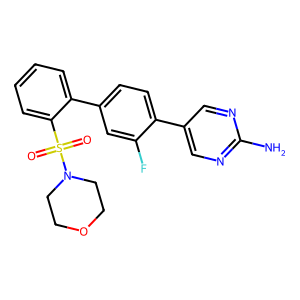
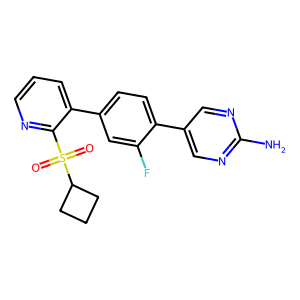
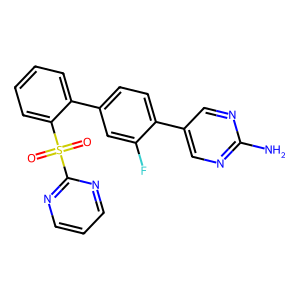
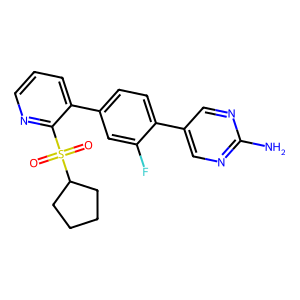
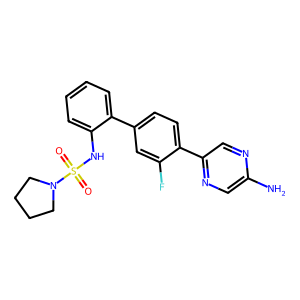
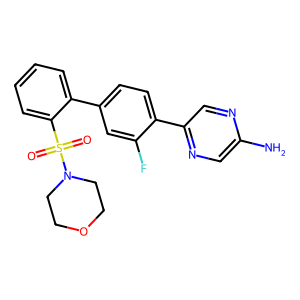

In [353]:
t517_d1_d

# Similarities within the clusters

In [94]:
from sklearn.cluster import KMeans
from cliffs import *
import seaborn as sns
import matplotlib.pyplot as plt

In [95]:
num_clusters = 5 # can be adjusted
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
clusters = kmeans.fit_predict(umap_res1)

t517_d1_d['Cluster'] = clusters

In [96]:
# take the max of the similarities
def get_max_similarity_matrix(smiles, radius=2, nBits=1024):
    size = len(smiles)
    max_similarity_matrix = np.zeros((size, size))
    max_similarity_metric = np.full((size, size), '', dtype=object)

    for i in trange(size):
        for j in range(i, size):
            if i == j:
                max_similarity_matrix[i, j] = 1
                max_similarity_metric[i, j] = 'Self'
            else:
                lev_sim = levenshtein(smiles[i], smiles[j])
                tan_sim = tanimoto(smiles[i], smiles[j], radius, nBits)
                sca_sim = scaffold_tanimoto(smiles[i], smiles[j], radius, nBits)
                max_sim = max(lev_sim, tan_sim, sca_sim)

                if max_sim == lev_sim:
                    metric = 'Levenshtein'
                elif max_sim == tan_sim:
                    metric = 'Structure similarity'
                else:
                    metric = 'Scaffold similarity'

                max_similarity_matrix[i, j] = max_sim
                max_similarity_matrix[j, i] = max_sim
                max_similarity_metric[i, j] = metric
                max_similarity_metric[j, i] = metric

    return max_similarity_matrix, max_similarity_metric

100%|██████████| 14/14 [00:00<00:00, 13605.25it/s]


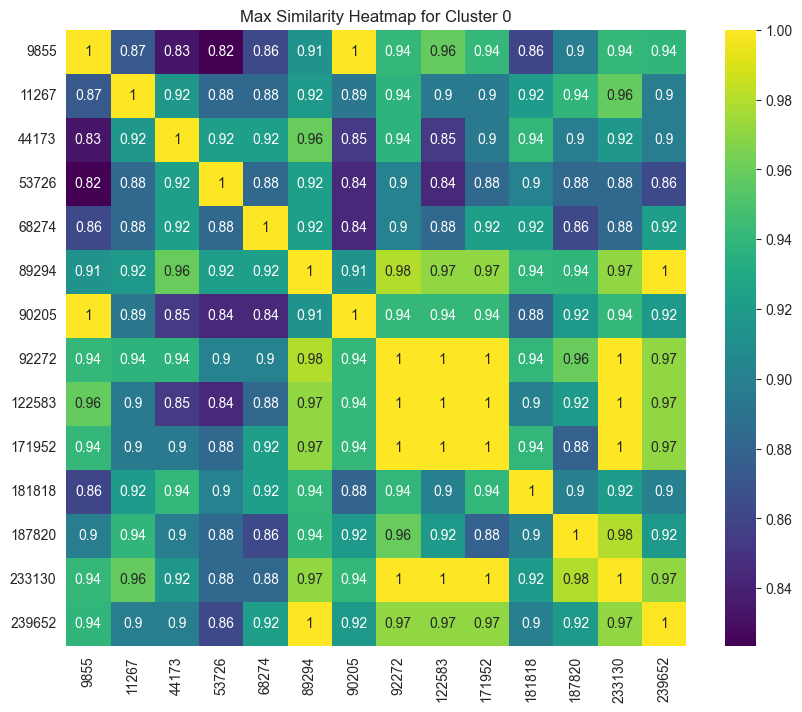

Similarity metrics for Cluster 0:
                      9855         11267        44173        53726   \
9855                   Self  Levenshtein  Levenshtein  Levenshtein   
11267           Levenshtein         Self  Levenshtein  Levenshtein   
44173           Levenshtein  Levenshtein         Self  Levenshtein   
53726           Levenshtein  Levenshtein  Levenshtein         Self   
68274           Levenshtein  Levenshtein  Levenshtein  Levenshtein   
89294   Scaffold similarity  Levenshtein  Levenshtein  Levenshtein   
90205   Scaffold similarity  Levenshtein  Levenshtein  Levenshtein   
92272   Scaffold similarity  Levenshtein  Levenshtein  Levenshtein   
122583          Levenshtein  Levenshtein  Levenshtein  Levenshtein   
171952  Scaffold similarity  Levenshtein  Levenshtein  Levenshtein   
181818          Levenshtein  Levenshtein  Levenshtein  Levenshtein   
187820          Levenshtein  Levenshtein  Levenshtein  Levenshtein   
233130  Scaffold similarity  Levenshtein  Levenshtein  

100%|██████████| 10/10 [00:00<?, ?it/s]


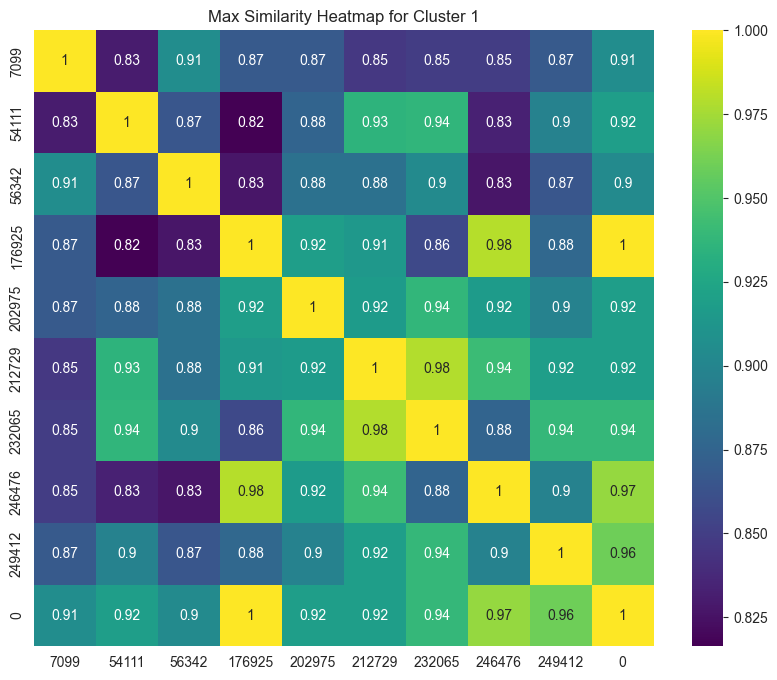

Similarity metrics for Cluster 1:
                      7099         54111        56342                176925  \
7099                   Self  Levenshtein  Levenshtein          Levenshtein   
54111           Levenshtein         Self  Levenshtein          Levenshtein   
56342           Levenshtein  Levenshtein         Self          Levenshtein   
176925          Levenshtein  Levenshtein  Levenshtein                 Self   
202975          Levenshtein  Levenshtein  Levenshtein          Levenshtein   
212729  Scaffold similarity  Levenshtein  Levenshtein  Scaffold similarity   
232065          Levenshtein  Levenshtein  Levenshtein          Levenshtein   
246476          Levenshtein  Levenshtein  Levenshtein          Levenshtein   
249412          Levenshtein  Levenshtein  Levenshtein          Levenshtein   
0               Levenshtein  Levenshtein  Levenshtein  Scaffold similarity   

             202975               212729       232065               246476  \
7099    Levenshtein  Scaffol

100%|██████████| 20/20 [00:00<?, ?it/s]


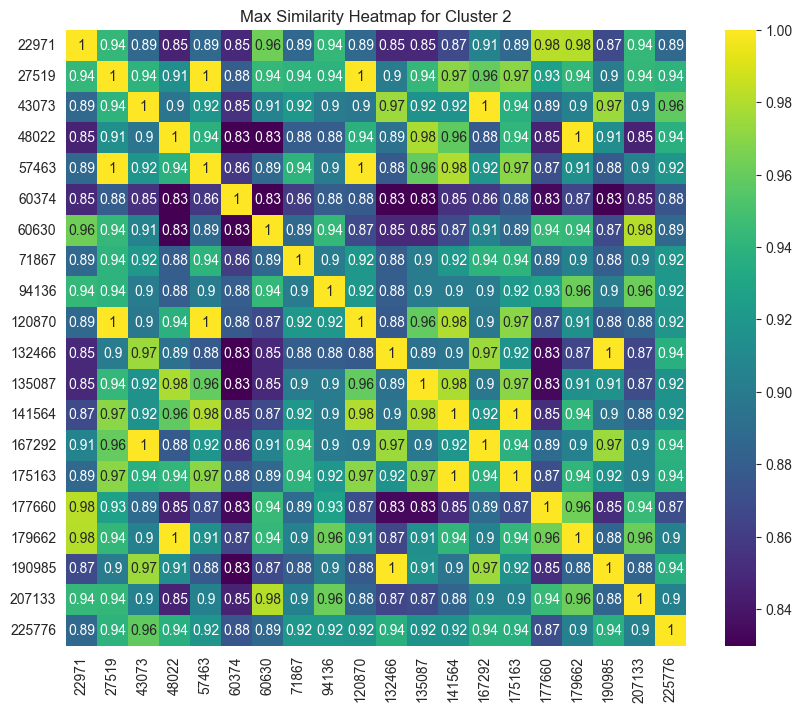

Similarity metrics for Cluster 2:
                      22971                27519                 43073   \
22971                  Self          Levenshtein           Levenshtein   
27519           Levenshtein                 Self           Levenshtein   
43073           Levenshtein          Levenshtein                  Self   
48022   Scaffold similarity  Scaffold similarity           Levenshtein   
57463           Levenshtein  Scaffold similarity           Levenshtein   
60374           Levenshtein          Levenshtein           Levenshtein   
60630           Levenshtein          Levenshtein           Levenshtein   
71867           Levenshtein          Levenshtein           Levenshtein   
94136           Levenshtein          Levenshtein           Levenshtein   
120870          Levenshtein  Scaffold similarity           Levenshtein   
132466          Levenshtein          Levenshtein   Scaffold similarity   
135087          Levenshtein  Scaffold similarity           Levenshtein   
141

100%|██████████| 18/18 [00:00<00:00, 14788.93it/s]


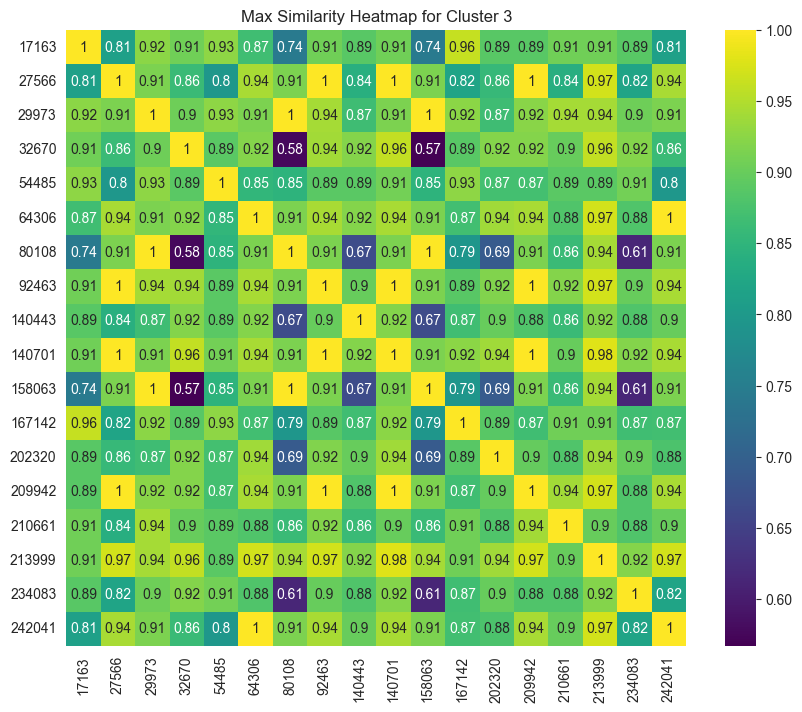

Similarity metrics for Cluster 3:
                      17163                27566                29973   \
17163                  Self          Levenshtein          Levenshtein   
27566           Levenshtein                 Self  Scaffold similarity   
29973           Levenshtein  Scaffold similarity                 Self   
32670           Levenshtein          Levenshtein          Levenshtein   
54485           Levenshtein          Levenshtein          Levenshtein   
64306           Levenshtein  Scaffold similarity  Scaffold similarity   
80108   Scaffold similarity  Scaffold similarity  Scaffold similarity   
92463           Levenshtein  Scaffold similarity          Levenshtein   
140443          Levenshtein          Levenshtein          Levenshtein   
140701          Levenshtein  Scaffold similarity  Scaffold similarity   
158063  Scaffold similarity  Scaffold similarity  Scaffold similarity   
167142          Levenshtein  Scaffold similarity          Levenshtein   
202320          

100%|██████████| 11/11 [00:00<?, ?it/s]


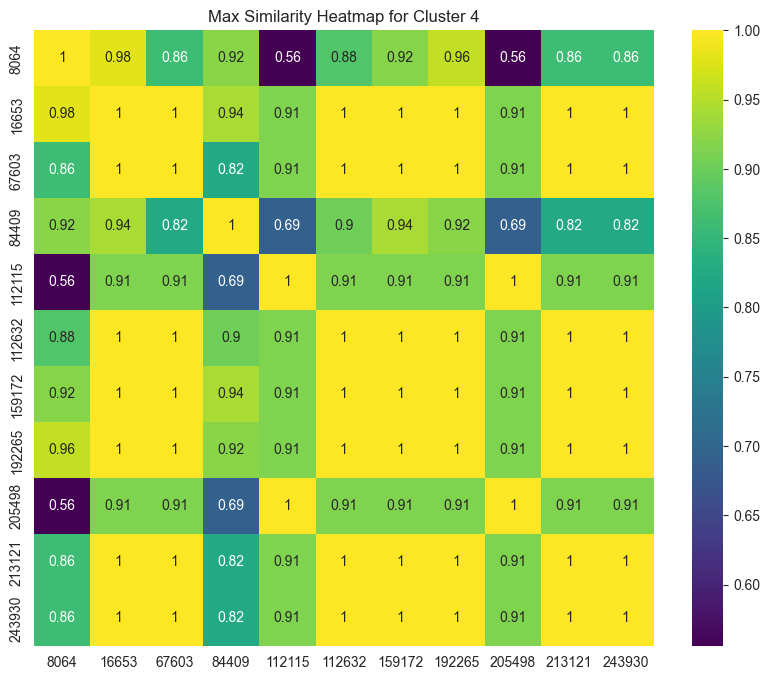

Similarity metrics for Cluster 4:
                      8064                 16653                67603   \
8064                   Self          Levenshtein          Levenshtein   
16653           Levenshtein                 Self  Scaffold similarity   
67603           Levenshtein  Scaffold similarity                 Self   
84409           Levenshtein          Levenshtein          Levenshtein   
112115  Scaffold similarity  Scaffold similarity  Scaffold similarity   
112632          Levenshtein  Scaffold similarity  Scaffold similarity   
159172          Levenshtein  Scaffold similarity  Scaffold similarity   
192265          Levenshtein  Scaffold similarity  Scaffold similarity   
205498  Scaffold similarity  Scaffold similarity  Scaffold similarity   
213121          Levenshtein  Scaffold similarity  Scaffold similarity   
243930          Levenshtein  Scaffold similarity  Scaffold similarity   

                     84409                112115               112632  \
8064           

In [97]:
for cluster in range(num_clusters):
    cluster_indices = t517_d1_d[t517_d1_d['Cluster'] == cluster].index.tolist()
    cluster_smiles = t517_d1_d.loc[cluster_indices, 'smiles2'].tolist()
    max_similarity_matrix, max_similarity_metric = get_max_similarity_matrix(cluster_smiles)
    
    # Convert to DataFrame for better readability
    similarity_df = pd.DataFrame(max_similarity_matrix, columns=cluster_indices, index=cluster_indices)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(similarity_df, annot=True, cmap='viridis')
    plt.title(f"Max Similarity Heatmap for Cluster {cluster}")
    plt.show()
    
    # Display the metric used for the maximum similarity
    metric_df = pd.DataFrame(max_similarity_metric, columns=cluster_indices, index=cluster_indices)
    print(f"Similarity metrics for Cluster {cluster}:\n", metric_df)

In [100]:
t517_d1_d['UMAP Dimension 1'] = umap_res1[:, 0]
t517_d1_d['UMAP Dimension 2'] = umap_res1[:, 1]
t517_d1_d['index'] = t517_d1_d.index
t517_d1_d['Cluster'] = t517_d1_d['Cluster'].astype(str)

In [101]:
colors = px.colors.qualitative.Vivid  

fig = px.scatter(
    t517_d1_d,
    x='UMAP Dimension 1',
    y='UMAP Dimension 2',
    color='Cluster',
    hover_data={'index': True, 'Cluster': True},
    title='UMAP Visualization of Compounds with Cluster Coloring',
    color_discrete_sequence=colors  
)

fig.show()

pio.write_html(fig, file='../analysis/umap_clusters.html', auto_open=True)